# Traffic Light Detection with Transfer Learning
In this notebook, we learn how to use [Tensorflow Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection) to fine-tune a pretrained model on our own dataset/labels (our dataset can be small). We discuss the following points

* create our own traffic light dataset: images and annotations
* ensemble our dataset into TFRecord format
* use [Tensorflow Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection) to fine-tune a pretrained model

## Traffic Light Dataset
We can extract traffic light images from ROS (simulator) using the following command
```
rosrun image_view image_saver image:=/image_color
```
or from ROS-bag by starting 3 terminals
```
# terminal 1 - run a master
roscore

# terminal 2 - play the bag file
rosbag play -l PATH_TO_BAG_FILE

# terminal 3 - collect images
rosrun image_view image_saver image:=/img_topic
```

To create annotated data one can use [labelImg](https://github.com/tzutalin/labelImg), to save time we re-use annotated data from this [repository](https://github.com/coldKnight/TrafficLight_Detection-TensorFlowAPI) or directly from [here](https://drive.google.com/file/d/0B-Eiyn-CUQtxdUZWMkFfQzdObUE/view?usp=sharing).


The annotations are stored in `real_data_annotations.yaml` and `sim_data_annotations.yaml`. 

Let's visualize one example

In [1]:
import glob
import yaml
import os
import sys
import tensorflow as tf
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
additional_paths = ['..', '../slim']
for i, additional_path in enumerate(additional_paths):
    if not additional_path in sys.path:
        sys.path.insert(i, additional_path)
    
from object_detection.utils import dataset_util
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [5]:
yaml_file = '../dataset-sdcnd-capstone/sim_training_data/sim_data_annotations.yaml'
with open(yaml_file, 'rb') as f:
    annotated_samples = yaml.load(f.read())  
    
label_map_dict = label_map_util.get_label_map_dict('../label_map.pbtxt')    

category_index = {}
for k,v in label_map_dict.items():
    category_index[v] = {'name' : k}
    
category_index

{1: {'name': u'Red'},
 2: {'name': u'Yellow'},
 3: {'name': u'Green'},
 4: {'name': u'NoTrafficLight'}}

In [6]:
real_yaml = '../dataset-sdcnd-capstone/real_training_data/real_data_annotations.yaml'
with open(real_yaml, 'rb') as f:
    real_annotated_samples = yaml.load(f.read())  

In [7]:
real_annotated_samples[0]

{'annotations': [{'class': 'Green',
   'x_width': 18.75485956035061,
   'xmin': 647.417752023305,
   'y_height': 55.514384298637935,
   'ymin': 417.6439297524945}],
 'class': 'image',
 'filename': 'green/left0000.jpg'}

In [8]:
annotated_samples[0]    

{'annotations': [{'class': 'Green',
   'x_width': 52.65248226950354,
   'xmin': 130.4964539007092,
   'y_height': 119.60283687943263,
   'ymin': 289.36170212765956},
  {'class': 'Green',
   'x_width': 50.156028368794296,
   'xmin': 375.60283687943263,
   'y_height': 121.87234042553195,
   'ymin': 293.90070921985813},
  {'class': 'Green',
   'x_width': 53.33333333333326,
   'xmin': 623.6595744680851,
   'y_height': 119.82978723404256,
   'ymin': 297.7588652482269}],
 'class': 'image',
 'filename': 'sim_data_capture/left0003.jpg'}

In [24]:
for sample in annotated_samples:
    labels = set()
    for annotation in sample['annotations']:
        labels.add(annotation['class'])
    if len(labels) > 1:
        print (sample)

In [25]:
for sample in real_annotated_samples:
    labels = set()
    for annotation in sample['annotations']:
        labels.add(annotation['class'])
    if len(labels) > 1:
        print (sample)

In [9]:
def load_img_as_ndarray(img_file):
    image = Image.open(img_file)
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

def draw(data_dir, annotated_sample, figsize=(15,10)):
    img_file = os.path.join(data_dir, annotated_sample['filename'])
    img = load_img_as_ndarray(img_file)
    boxes = []
    classes = []
    scores = []
    for annotation in annotated_sample['annotations']:
        classes.append(label_map_dict[annotation['class']])
        xmin = annotation['xmin']
        ymin = annotation['ymin']
        xmax = annotation['x_width'] + xmin
        ymax = annotation['y_height'] + ymin
        
        boxes.append([ymin, xmin, ymax, xmax])
        scores.append(1)
    boxes = np.array(boxes)
    img_bb = vis_util.visualize_boxes_and_labels_on_image_array(
        img,
        boxes,
        classes,
        scores,
        category_index
    )
    
    
    fig = plt.figure(figsize=figsize)
    plt.imshow(img_bb)

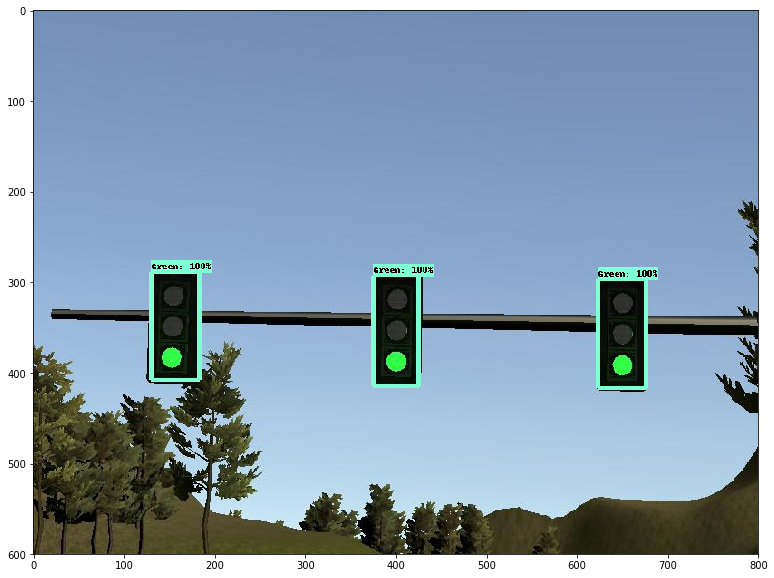

In [10]:
draw('../dataset-sdcnd-capstone/sim_training_data', annotated_samples[0])

In [11]:
img = load_img_as_ndarray('../dataset-sdcnd-capstone/real_training_data/green/left0000.jpg')
print(img.shape)

(1096, 1368, 3)


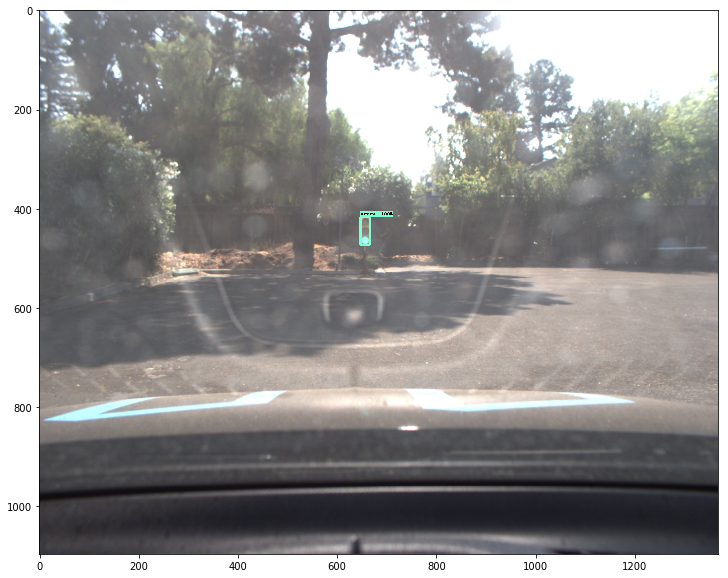

In [12]:
draw('../dataset-sdcnd-capstone/real_training_data', real_annotated_samples[0])

## Create TFRecord
We know that TFRecord is well supported by [Tensorflow Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection), so we create a script `create_tfrecord.py` to create TFRecord from our dataset. One can use the following command

```[bash]
# convert sim-data to TFRecord
python create_tfrecord.py --data_dir=dataset-sdcnd-capstone/sim_training_data \
    --label_map_path=./label_map.pbtxt --img_h=600 --img_w=800 \
    --output_path=sim.record
    
# convert real-data to TFRecord    
python create_tfrecord.py --data_dir=dataset-sdcnd-capstone/real_training_data \
    --label_map_path=./label_map.pbtxt --img_h=1096 --img_w=1368 \
    --output_path=real.record
```

## Fine-tune pretrained model
We follow the tutorial [pet detector](https://github.com/tensorflow/models/tree/master/research/object_detection), the required steps are

* download trained-model from [model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md)
* configure a object detection pipeline
* train (fine-tune) from the trained-model and test it with test data

We look at the following two models
* [ssd_inception_v2_coco](http://download.tensorflow.org/models/object_detection/ssd_inception_v2_coco_2018_01_28.tar.gz)
* [faster_rcnn_resnet50_coco](http://download.tensorflow.org/models/object_detection/faster_rcnn_resnet50_coco_2018_01_28.tar.gz)

To train with `faster_rcnn_resnet50_coco`, we use the following command
```[bash]
python object_detection/legacy/train.py \
--pipeline_config_path=trained_models/config/faster_rcnn_resnet50_coco_carnd_sim.config \
--train_dir finetuned_models/faster_rcnn_resnet50_coco
```

## Export finetuned model for inference
Now we have a finetuned model, 

In [13]:
def import_graph(model_path):
    detection_graph = tf.Graph()
    
    with detection_graph.as_default():
      od_graph_def = tf.GraphDef()
    
      with tf.gfile.GFile(model_path, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')
        
    return detection_graph

In [14]:
def predict(detection_graph, image_paths):
    with detection_graph.as_default():
        with tf.Session(graph=detection_graph) as sess:
            # Definite input and output Tensors for detection_graph
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

            # Each box represents a part of the image where a particular object was detected.
            detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

            # Each score represent how level of confidence for each of the objects.
            # Score is shown on the result image, together with the class label.
            detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
            detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')
            for image_path in image_paths:
                image = Image.open(image_path)
                # the array based representation of the image will be used later in order to prepare the
                # result image with boxes and labels on it.
                image_np = load_image_into_numpy_array(image)
                
                # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
                image_np_expanded = np.expand_dims(image_np, axis=0)
                print(image_np.shape)

                time0 = time.time()

                # Actual detection.
                (boxes, scores, classes, num) = sess.run(
                  [detection_boxes, detection_scores, detection_classes, num_detections],
                  feed_dict={image_tensor: image_np_expanded})

                time1 = time.time()

                boxes = np.squeeze(boxes)
                scores = np.squeeze(scores)
                classes = np.squeeze(classes).astype(np.int32)

                # Visualization of the results of a detection.
                vis_util.visualize_boxes_and_labels_on_image_array(
                    image_np, boxes, classes, scores,
                    category_index,
                    use_normalized_coordinates=True,
                    line_thickness=6)

                plt.figure(figsize=image_size)
                plt.imshow(image_np)
                plt.show()

                min_score_thresh = .50
                for i in range(boxes.shape[0]):
                    if scores is None or scores[i] > min_score_thresh:

                        class_name = category_index[classes[i]]['name']
                        print('{}'.format(class_name), scores[i])

                        fx =  0.97428
                        fy =  1.73205
                        perceived_width_x = (boxes[i][3] - boxes[i][1]) * 800
                        perceived_width_y = (boxes[i][2] - boxes[i][0]) * 600

                        # ymin, xmin, ymax, xmax = box
                        # depth_prime = (width_real * focal) / perceived_width
                        perceived_depth_x = ((.1 * fx) / perceived_width_x)
                        perceived_depth_y = ((.3 * fy) / perceived_width_y )

                        estimated_distance = round((perceived_depth_x + perceived_depth_y) / 2)
                        #print("Distance (metres)", estimated_distance)
                        print("Time in milliseconds", (time1 - time0) * 1000, "\n")

In [15]:
detection_graph  = import_graph('../frozen_sim/ssd_mobilenet_v1_coco/frozen_inference_graph.pb')

In [16]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def load_test_images(directory):
    print(os.path.join(directory, '*.jpg'))
    image_paths = glob.glob(os.path.join(directory, '*.jpg'))
    print("Length of test images:", len(image_paths))
    return image_paths

In [18]:
image_paths = load_test_images("../media/tl_images/")

../media/tl_images/*.jpg
('Length of test images:', 20)


In [15]:
image_paths = load_test_images("/home/minhvu/workplaces/tl_imgs/")

/home/minhvu/workplaces/tl_imgs/*.jpg
Length of test images: 58


In [19]:
label_map = label_map_util.load_labelmap('../label_map.pbtxt')
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=4, use_display_name=True)
category_index = label_map_util.create_category_index(categories)
print(category_index)

{1: {'id': 1, 'name': u'Red'}, 2: {'id': 2, 'name': u'Yellow'}, 3: {'id': 3, 'name': u'Green'}, 4: {'id': 4, 'name': u'NoTrafficLight'}}


(600, 800, 3)


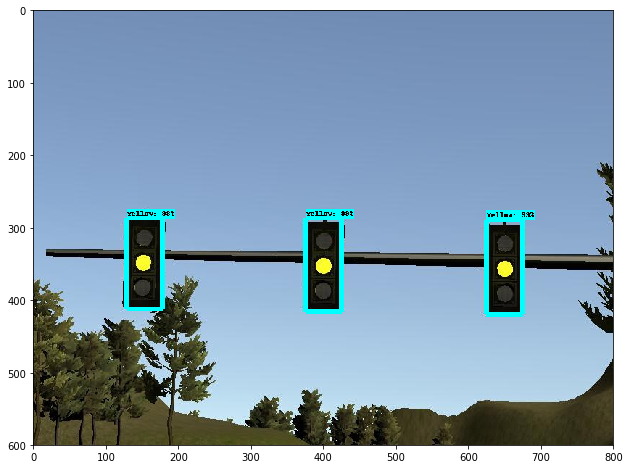

('Yellow', 0.99712151)
('Time in milliseconds', 337.7518653869629, '\n')
('Yellow', 0.99588364)
('Time in milliseconds', 337.7518653869629, '\n')
('Yellow', 0.98405623)
('Time in milliseconds', 337.7518653869629, '\n')
(600, 800, 3)


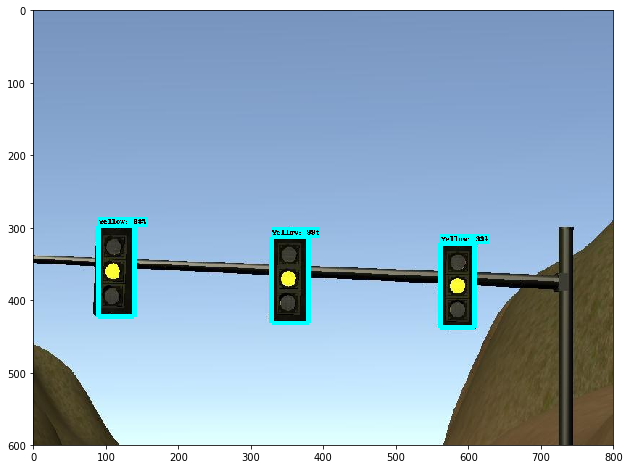

('Yellow', 0.99587017)
('Time in milliseconds', 74.4168758392334, '\n')
('Yellow', 0.99215102)
('Time in milliseconds', 74.4168758392334, '\n')
('Yellow', 0.98667973)
('Time in milliseconds', 74.4168758392334, '\n')


In [21]:
import time
image_size = (12, 8)

predict(detection_graph, image_paths[0:2])

We can visualize the bounding-box, next let's evaluate the accuracy on a dataset (we should not use training dataset for evaluate but since we don't have any other dataset so we compute the accuracy on training dataset)

In [43]:
from light_classification.tl_classifier import TLClassifier

tl_detector = TLClassifier('../frozen_sim/ssd_mobilenet_v1_coco/frozen_inference_graph.pb', 
                                         600, 
                                         800)

In [40]:
def get_tl(data_dir, tl_detector, sample):
    img_file = os.path.join(data_dir, sample['filename'])
    img = load_img_as_ndarray(img_file)
    labels = set()
    for annotation in sample['annotations']:
        labels.add(annotation['class'])
    labels = list(labels)
    if len(labels) == 0:
        labels = ['NoTrafficLight']
        
    predict_class = tl_detector.get_classification(img)
    print('Truth:   {:>10s}'.format(labels[0]))
    print('Predict: {:>10s}'.format(category_index[predict_class]['name']))

In [42]:
get_tl('../dataset-sdcnd-capstone/sim_training_data', tl_detector, annotated_samples[0])

Truth:        Green
Predict:      Green


In [47]:
class_to_id = {}
for k,v in category_index.items():
    class_to_id[str(v['name'])] = k

print(class_to_id)

{'NoTrafficLight': 4, 'Green': 3, 'Yellow': 2, 'Red': 1}


In [57]:
def evaluate(model_path, img_h, img_w, data_dir, samples):
    tl_detector = TLClassifier(model_path, img_h, img_w)
    nb_samples = 0
    nb_correct = 0
    wrong_idx = []
    running_time = []
    for i,sample in enumerate(samples):
        labels = set()
        for annotation in sample['annotations']:
            labels.add(annotation['class'])
        
        if len(labels) > 1:
            continue
        
        nb_samples += 1
        labels = list(labels)
        if len(labels)==0:
            truth = 4
        else:
            truth = class_to_id[labels[0]]
        
        img_file = os.path.join(data_dir, sample['filename'])
        img = load_img_as_ndarray(img_file)
        time0 = time.time()
        prediction = tl_detector.get_classification(img)
        elapsed = (time.time() - time0)*1000
        running_time.append(elapsed)
        
        if (prediction != truth):
            wrong_idx.append(i)
        else:
            nb_correct += 1
            
        sys.stdout.write('\rDone sample {:>3d}-th in {:.2f} ms'.format(i, elapsed))
        if (nb_samples % 10 == 0):
            print('')
            
    print('\nPrediction correct: {:>3d}/{:<4d} i.e {:.2f}%'.format(nb_correct, nb_samples, 100*nb_correct/nb_samples))
    return wrong_idx, running_time

In [49]:
ssd_mobilenet_v1_coco = '../frozen_sim/ssd_mobilenet_v1_coco/frozen_inference_graph.pb'
img_h = 600
img_w = 800
sim_dir = '../dataset-sdcnd-capstone/sim_training_data'

In [56]:
wrong_idx, running_time = evaluate(ssd_mobilenet_v1_coco, img_h, img_w, sim_dir, annotated_samples)

Done sample   9-th in 67.61 ms
Done sample  19-th in 67.16 ms
Done sample  29-th in 66.11 ms
Done sample  39-th in 71.94 ms
Done sample  49-th in 70.33 ms
Done sample  59-th in 71.09 ms
Done sample  69-th in 68.06 ms
Done sample  79-th in 66.66 ms
Done sample  89-th in 70.46 ms
Done sample  99-th in 68.56 ms
Done sample 109-th in 73.11 ms
Done sample 119-th in 75.21 ms
Done sample 129-th in 68.62 ms
Done sample 139-th in 71.96 ms
Done sample 149-th in 67.69 ms
Done sample 159-th in 68.63 ms
Done sample 169-th in 66.99 ms
Done sample 179-th in 69.67 ms
Done sample 189-th in 70.31 ms
Done sample 199-th in 65.82 ms
Done sample 209-th in 69.31 ms
Done sample 219-th in 74.43 ms
Done sample 229-th in 67.74 ms
Done sample 239-th in 68.74 ms
Done sample 249-th in 69.66 ms
Done sample 259-th in 71.19 ms
Done sample 269-th in 67.36 ms
Done sample 276-th in 68.77 msPrediction correct: 273/277  i.e 98.00%
